In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/customer-personality-analysis/marketing_campaign.csv


In [11]:
!pip install pytorch-tabnet category_encoders

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from category_encoders import OneHotEncoder
from sklearn.cluster import KMeans
from pytorch_tabnet.tab_model import TabNetClassifier
import torch


In [12]:
df = pd.read_csv("/kaggle/input/customer-personality-analysis/marketing_campaign.csv", sep="\t")

# Drop ID and dates for now
df = df.drop(columns=["ID", "Z_CostContact", "Z_Revenue", "Dt_Customer"])


In [13]:
# Fill missing income with median
df['Income'].fillna(df['Income'].median(), inplace=True)

# Total children
df['TotalChildren'] = df['Kidhome'] + df['Teenhome']

# Total spend
df['TotalSpend'] = df[[
    'MntWines', 'MntFruits', 'MntMeatProducts',
    'MntFishProducts', 'MntSweetProducts', 'MntGoldProds'
]].sum(axis=1)

# Campaign responses
df['CampaignResponses'] = df[[
    'AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5'
]].sum(axis=1)

# Encode categoricals
cat_features = ['Education', 'Marital_Status']
encoder = OneHotEncoder(cols=cat_features, use_cat_names=True)
df_encoded = encoder.fit_transform(df)

# Normalize numerical columns
numerical = df_encoded.select_dtypes(include=np.number).columns
scaler = StandardScaler()
df_encoded[numerical] = scaler.fit_transform(df_encoded[numerical])


<ipython-input-13-bdaaa9c89fd5>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Income'].fillna(df['Income'].median(), inplace=True)


In [14]:
# KMeans clustering for 5 personalities
kmeans = KMeans(n_clusters=5, random_state=42)
df_encoded["PersonalityCluster"] = kmeans.fit_predict(df_encoded)

# Map clusters to personality names manually (based on spend/engagement)
cluster_profiles = df_encoded.groupby("PersonalityCluster").mean()
cluster_names = {
    0: "Balanced Buyer",
    1: "Budget Conscious",
    2: "High Spender",
    3: "Detached Minimalist",
    4: "Campaign Enthusiast"
}
df_encoded["PersonalityLabel"] = df_encoded["PersonalityCluster"].map(cluster_names)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [15]:
# Define features and labels
X = df_encoded.drop(columns=["PersonalityCluster", "PersonalityLabel"])
y = df_encoded["PersonalityCluster"]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.2, random_state=42)

# Train TabNet
clf = TabNetClassifier(
    device_name='cuda' if torch.cuda.is_available() else 'cpu'
)

clf.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    max_epochs=100,
    patience=10,
    batch_size=256,
    virtual_batch_size=128,
    eval_metric=['accuracy']
)


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.03667 | val_0_accuracy: 0.39062 |  0:00:00s
epoch 1  | loss: 1.25699 | val_0_accuracy: 0.40848 |  0:00:00s
epoch 2  | loss: 0.96323 | val_0_accuracy: 0.50446 |  0:00:00s
epoch 3  | loss: 0.8063  | val_0_accuracy: 0.55134 |  0:00:00s
epoch 4  | loss: 0.64334 | val_0_accuracy: 0.57366 |  0:00:01s
epoch 5  | loss: 0.51444 | val_0_accuracy: 0.65625 |  0:00:01s
epoch 6  | loss: 0.42929 | val_0_accuracy: 0.70312 |  0:00:01s
epoch 7  | loss: 0.38435 | val_0_accuracy: 0.80804 |  0:00:01s
epoch 8  | loss: 0.32613 | val_0_accuracy: 0.84152 |  0:00:01s
epoch 9  | loss: 0.31651 | val_0_accuracy: 0.8683  |  0:00:02s
epoch 10 | loss: 0.27101 | val_0_accuracy: 0.86607 |  0:00:02s
epoch 11 | loss: 0.25445 | val_0_accuracy: 0.89062 |  0:00:02s
epoch 12 | loss: 0.22403 | val_0_accuracy: 0.88393 |  0:00:02s
epoch 13 | loss: 0.25384 | val_0_accuracy: 0.88393 |  0:00:02s
epoch 14 | loss: 0.21084 | val_0_accuracy: 0.90402 |  0:00:03s
epoch 15 | loss: 0.19073 | val_0_accuracy: 0.90625 |  0

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [16]:
from sklearn.metrics import classification_report

y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=list(cluster_names.values())))


                     precision    recall  f1-score   support

     Balanced Buyer       0.97      0.97      0.97       178
   Budget Conscious       0.88      0.90      0.89        93
       High Spender       0.00      0.00      0.00         1
Detached Minimalist       0.91      0.90      0.90       142
Campaign Enthusiast       1.00      0.94      0.97        34

           accuracy                           0.93       448
          macro avg       0.75      0.74      0.75       448
       weighted avg       0.93      0.93      0.93       448



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<ipython-input-18-f927959bf8da>:18: UserWarning: Glyph 128717 (\N{SHOPPING BAGS}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128717 (\N{SHOPPING BAGS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


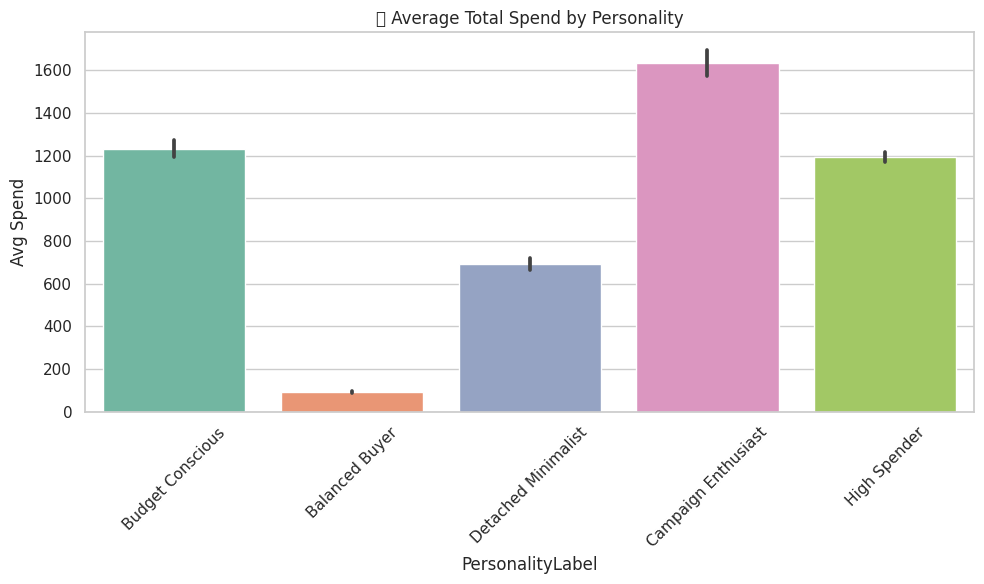

<ipython-input-18-f927959bf8da>:27: UserWarning: Glyph 128118 (\N{BABY}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128118 (\N{BABY}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


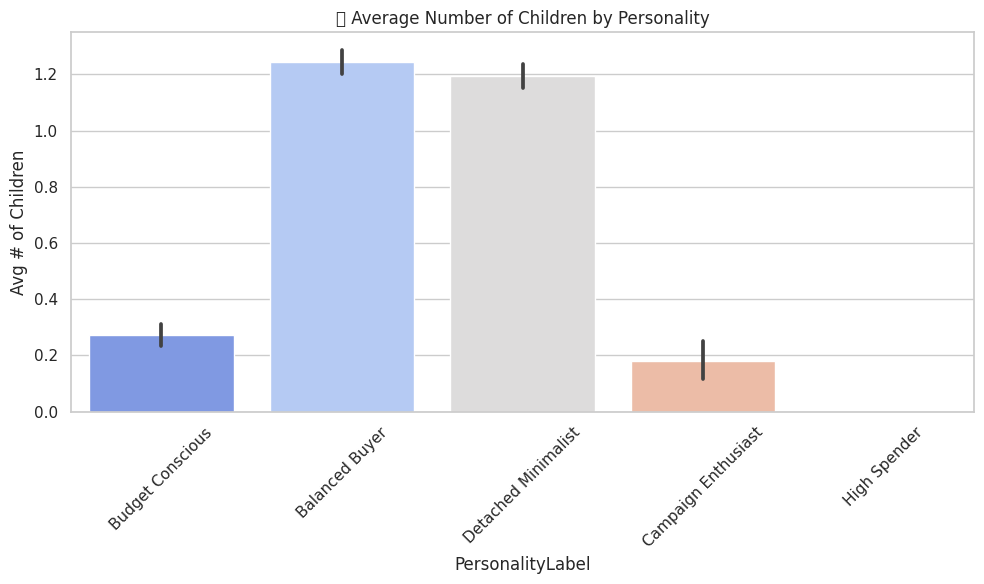

<ipython-input-18-f927959bf8da>:36: UserWarning: Glyph 128226 (\N{PUBLIC ADDRESS LOUDSPEAKER}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128226 (\N{PUBLIC ADDRESS LOUDSPEAKER}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


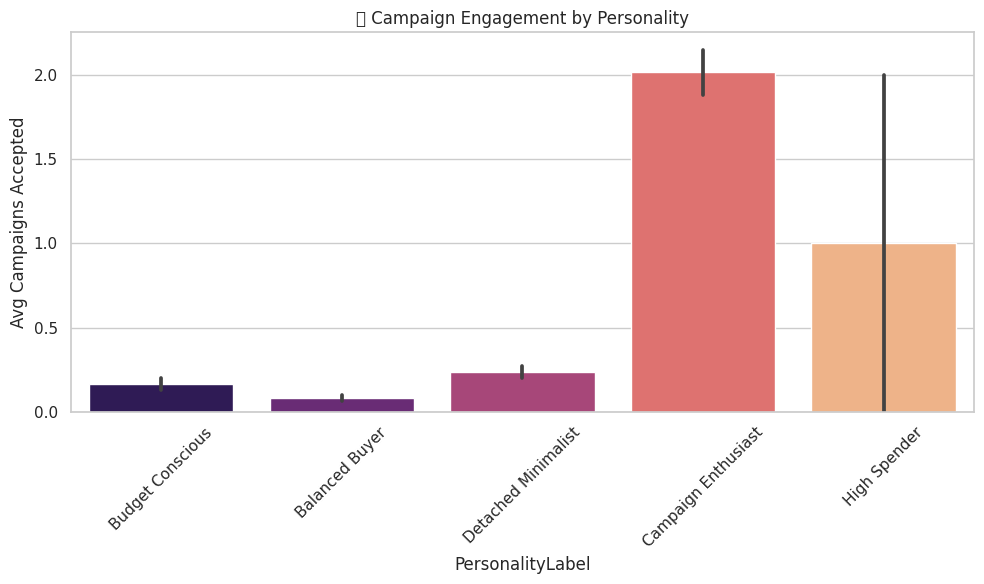

<ipython-input-18-f927959bf8da>:45: UserWarning: Glyph 9201 (\N{STOPWATCH}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9201 (\N{STOPWATCH}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


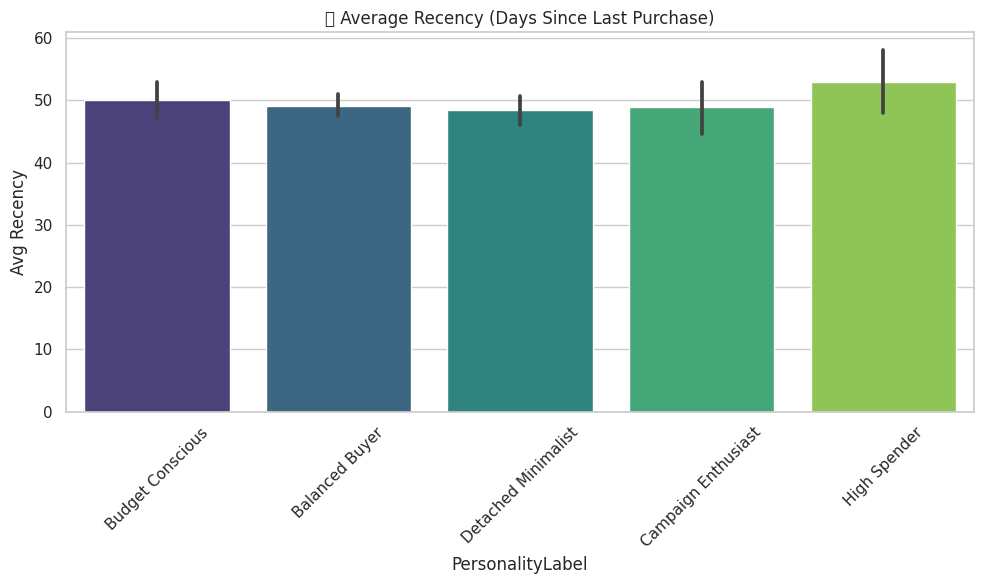

<ipython-input-18-f927959bf8da>:54: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


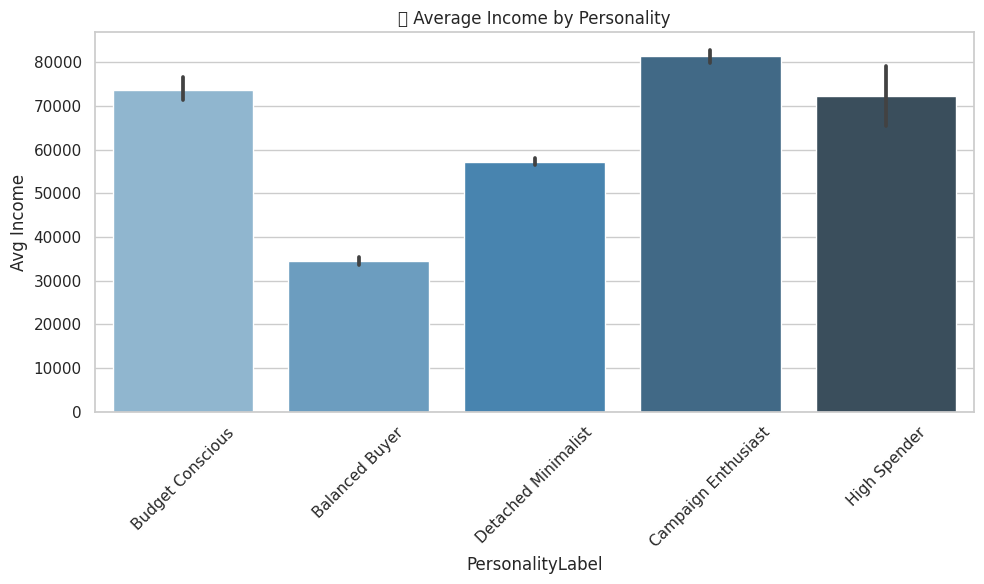

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# Merge with original unscaled data for better interpretation
df_viz = df.copy()
df_viz["PersonalityCluster"] = df_encoded["PersonalityCluster"]
df_viz["PersonalityLabel"] = df_encoded["PersonalityLabel"]

# Set consistent theme
sns.set(style="whitegrid")

# Plot average total spend by personality
plt.figure(figsize=(10, 6))
sns.barplot(data=df_viz, x="PersonalityLabel", y="TotalSpend", estimator=np.mean, palette="Set2")
plt.title("🛍️ Average Total Spend by Personality")
plt.ylabel("Avg Spend")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot average number of children
plt.figure(figsize=(10, 6))
sns.barplot(data=df_viz, x="PersonalityLabel", y="TotalChildren", estimator=np.mean, palette="coolwarm")
plt.title("👶 Average Number of Children by Personality")
plt.ylabel("Avg # of Children")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot campaign responses
plt.figure(figsize=(10, 6))
sns.barplot(data=df_viz, x="PersonalityLabel", y="CampaignResponses", estimator=np.mean, palette="magma")
plt.title("📢 Campaign Engagement by Personality")
plt.ylabel("Avg Campaigns Accepted")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot recency (last purchase)
plt.figure(figsize=(10, 6))
sns.barplot(data=df_viz, x="PersonalityLabel", y="Recency", estimator=np.mean, palette="viridis")
plt.title("⏱️ Average Recency (Days Since Last Purchase)")
plt.ylabel("Avg Recency")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot income
plt.figure(figsize=(10, 6))
sns.barplot(data=df_viz, x="PersonalityLabel", y="Income", estimator=np.mean, palette="Blues_d")
plt.title("💰 Average Income by Personality")
plt.ylabel("Avg Income")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [20]:
# Original input dictionary
sample_input = {
    "Year_Birth": 1985,
    "Education": "Graduation",
    "Marital_Status": "Single",
    "Income": 45000,
    "Kidhome": 0,
    "Teenhome": 1,
    "Recency": 10,
    "MntWines": 200,
    "MntFruits": 20,
    "MntMeatProducts": 150,
    "MntFishProducts": 30,
    "MntSweetProducts": 25,
    "MntGoldProds": 50,
    "NumDealsPurchases": 2,
    "NumWebPurchases": 3,
    "NumCatalogPurchases": 1,
    "NumStorePurchases": 4,
    "NumWebVisitsMonth": 5,
    "AcceptedCmp1": 0,
    "AcceptedCmp2": 0,
    "AcceptedCmp3": 0,
    "AcceptedCmp4": 1,
    "AcceptedCmp5": 0,
    "Complain": 0
}
# Create a copy of the original columns used in training
original_input_columns = df.columns.tolist()

# Ensure all expected features are in the input_df
for col in original_input_columns:
    if col not in input_df.columns:
        if col in ['Education', 'Marital_Status']:
            input_df[col] = "Missing"  # default filler for unseen categories
        else:
            input_df[col] = 0  # numerical default

# Reorder columns to match training order
input_df = input_df[original_input_columns]

# Apply the same encoder and scaler
input_encoded = encoder.transform(input_df)
input_encoded[numerical] = scaler.transform(input_encoded[numerical])

# Add any missing one-hot columns (if needed)
missing_cols = [col for col in X.columns if col not in input_encoded.columns]
for col in missing_cols:
    input_encoded[col] = 0

# Ensure order matches model input
input_encoded = input_encoded[X.columns]

# Predict
pred_cluster = clf.predict(input_encoded.values)[0]
pred_personality = cluster_names[pred_cluster]

print(f"🧠 Predicted Personality Cluster: {pred_cluster} ➡️ {pred_personality}")


🧠 Predicted Personality Cluster: 3 ➡️ Detached Minimalist
